# Demo
Integrating sub-cellular spots into single-cellular spots based on an improved version of TopACT (i.e., pytacs here).

In [1]:
import pytacs
import scanpy as sc
import seaborn as sns

In [2]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('snRNA_mouse_demo.h5ad'),
    sp_adata=sc.read_h5ad('spRNA_mouse_demo.h5ad'),
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [3]:
data_preper.simulate_negative_control(ratio_samplingFrom=0.2, negative_samples_proportion=0.2, ratio_mask=0.7)

AnnData object with n_obs × n_vars = 2500 × 769
    obs: 'cell_type'

In [4]:
data_preper.normalize()
data_preper

v1.0.0 - normalization has bugs. Do not use it for now! Skip.


--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: AnnData object with n_obs × n_vars = 2500 × 769
    obs: 'cell_type'
- normalized: False
--- --- --- --- ---

In [5]:
# Step 2. Train a local classifer
clf = pytacs.GaussianNaiveBayes(threshold_confidence=0.3)
clf.fit(
    sn_adata=data_preper.sn_adata_withNegativeControl
)

In [6]:
# Step 3. Integrate spatial spots into single-cell spots
sph = pytacs.SpatialHandler(adata_spatial=data_preper.sp_adata,
                            local_classifier=clf,
                            max_spots_per_cell=64,
                            threshold_adjacent=1.2,
                            )
print(sph)

--- Spatial Handler (pytacs) ---
- adata_spatial: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- threshold_adjacent: 1.2
- local_classifier: <pytacs.classifier.GaussianNaiveBayes object at 0x7f1605ef1820>
    + threshold_confidence: 0.3
    + has_negative_control: True
- max_spots_per_cell: 64
- scale_rbf: 1.0
- filtrations: 0 fitted
- single-cell segmentation:
    + new samples: 0
    + AnnData: _UNDEFINED
--- --- --- --- --- ---



In [7]:
sph.run_segmentation(
    coverage_to_stop=0.1,
    max_iter=300,
    verbose=True,
    warnings=False,
    print_summary=True,
)

Iteration 1:
Querying spot 2732 ...
Spot 2732 | confidence: 95.704% | confident total: 1 | class: 1
Classes total: {1: 1}
Coverage: 0.06%
Iteration 6:
Querying spot 1253 ...
Spot 1253 | confidence: 100.000% | confident total: 3 | class: 1
Classes total: {1: 2, 0: 1}
Coverage: 1.14%
Iteration 11:
Querying spot 4256 ...
Spot 4256 | confidence: 100.000% | confident total: 7 | class: 0
Classes total: {1: 3, 0: 4}
Coverage: 2.59%
Iteration 16:
Querying spot 1194 ...
Spot 1194 | confidence: 100.000% | confident total: 10 | class: 0
Classes total: {1: 5, 0: 5}
Coverage: 3.51%
Iteration 21:
Querying spot 4722 ...
Spot 4722 | confidence: 99.578% | confident total: 15 | class: 1
Classes total: {1: 8, 0: 7}
Coverage: 4.56%
Iteration 26:
Querying spot 2918 ...
Spot 2918 | confidence: 98.363% | confident total: 19 | class: 1
Classes total: {1: 11, 0: 8}
Coverage: 6.06%
Iteration 31:
Querying spot 914 ...
Spot 914 | confidence: 100.000% | confident total: 24 | class: 1
Classes total: {1: 16, 0: 8}
C

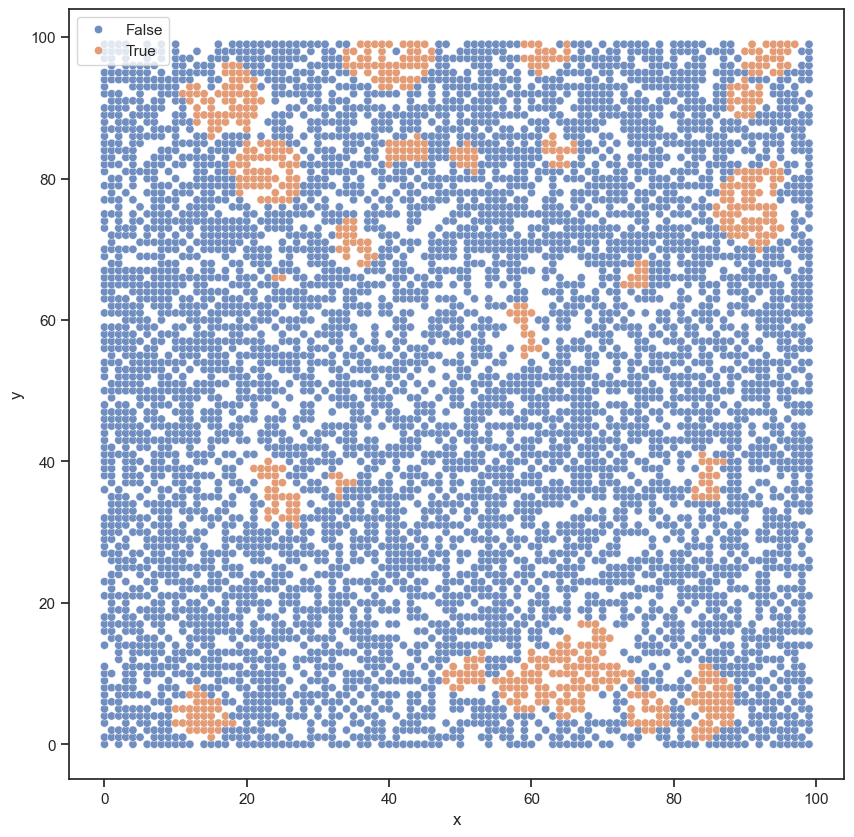

In [8]:
# See the integrated spots
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.set_theme(style='ticks')
sns.scatterplot(
    x=data_preper.sp_adata.obs['x'],
    y=data_preper.sp_adata.obs['y'],
    hue=sph.mask_newIds>-1,
    alpha=0.8,
)
plt.show()
# I used to use a 8-neighbor strategy so the shape might look quite dispersed;
# you can lower the threshold_adjacent to 1.2 or so to apply a 4-neighbor
# strategy for the shape to be denser.

In [9]:
# Get integrated single-cell level ST data
sp_singleCell = sph.run_getSingleCellAnnData(cache=True, force=True)

In [10]:
print(sp_singleCell)

AnnData object with n_obs × n_vars = 27 × 5227
    obs: 'x', 'y', 'old_index', 'confidence'


In [11]:
sp_singleCell.obs['confidence']

914     1.000000
1194    1.000000
1253    1.000000
1655    0.860673
1757    1.000000
1775    1.000000
2265    1.000000
2478    1.000000
2732    0.957040
2743    0.808242
2918    0.983634
3361    0.999999
3404    1.000000
3900    0.786166
3995    1.000000
4137    1.000000
4256    1.000000
4537    0.977735
4722    0.995777
4934    1.000000
4964    1.000000
5408    1.000000
5497    0.942391
5945    1.000000
6065    1.000000
6148    0.353042
6200    0.946925
Name: confidence, dtype: float64

In [12]:
sp_singleCell['2918',:].obs

,x,y,old_index,confidence
2918,43,84,"43,84",0.983634
